# Q5. Decrypting Messages with MCMC

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from collections import Counter
from unidecode import unidecode
from operator import itemgetter
import random
import math
import csv

def text_cleaning(symbol_file='symbols.txt', message_file='message.txt', training_file='war_and_peace_tolstoi.txt', ):
    # Loading the text, and estimating the transition probabilities

    with open('war_and_peace_tolstoi.txt', 'r', encoding='utf-8') as file:
        warpeace = file.read().lower()

    with open('symbols.txt', 'r', encoding='utf-8') as symbol_file:
        symbols_list = symbol_file.read().splitlines()

    with open('message.txt', 'r', encoding='utf-8') as message_file:
        message = message_file.read()

    warpeace_clean = unidecode(warpeace)
    warpeace_clean = warpeace_clean.replace('\n', ' ').replace('#', '').replace('%', '').replace('$', '')

    return symbols_list, message, warpeace_clean

def transition_counts(warpeace_clean):
    # Keeping track of the number of counts of:
    # 1) Each symbol
    symbols_found = Counter()
    # 2) Each pair of symbols
    pair_found = Counter()
    
    for i in range(len(warpeace_clean)-1):
        s_i_minus_1 = warpeace_clean[i]
        s_i = warpeace_clean[i+1]
        pair_found[(s_i_minus_1, s_i)] += 1
        symbols_found[s_i_minus_1] += 1
    
    return symbols_found, pair_found

In [7]:
def psi_phi_calculations(symbols_found, pair_found, precision=1e-9):

    transition_probabilities = {}

    for (s_i_minus_1, s_i), frequency_pair in pair_found.items():
        transition_probabilities[s_i_minus_1, s_i] = frequency_pair/(symbols_found[s_i_minus_1])

    unsorted_symbol_states = set([i[0] for i in transition_probabilities.keys()] + [i[1] for i in transition_probabilities.keys()])
    symbol_states = sorted(unsorted_symbol_states)
    n_symbols = len(symbol_states)

    symbol_indexes = {symbol: i for i, symbol in enumerate(symbol_states)}
    
    # Transition probabilities matrix
    psi = np.zeros((n_symbols, n_symbols))
    for (s_i_minus_1, s_i), p_current_given_previous in transition_probabilities.items():
        i = symbol_indexes[s_i_minus_1]
        j = symbol_indexes[s_i]
        psi[i, j] = p_current_given_previous

    # Adapting for ergodicity, after answering question 5.(e)
    for i in range(np.shape(psi)[0]):
        for j in range(np.shape(psi)[0]):
            if psi[i,j] == 0:
                psi[i,j] += precision


    eigenvalues, eigenvectors = np.linalg.eig(psi.T)
    stationary_vector = eigenvectors[:, np.isclose(eigenvalues, 1)]
    stationary_distribution = (stationary_vector.real / np.sum(stationary_vector))

    stationary_distribution_dict = {symbol: stationary_distribution[symbol_indexes[symbol]].real for symbol in symbol_states}

    stationary_probabilities = [i for i in stationary_distribution_dict.values()]

    return psi, stationary_distribution_dict, symbol_indexes, stationary_probabilities 


def save_csv_data_transition(psi, filename="transition_probabilities.csv"):
    psi_array = np.array(psi)
    clean_data_transition = [[f"{value:.2e}" for value in row] for row in psi_array] 

    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerows(clean_data_transition)

def save_csv_data_stationary(stationary_distribution_dict, filename="stationary_probabilities.csv"):
    with open(filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Symbol", "Stationary Probability"])  # Header row
        for symbol, probability in stationary_distribution_dict.items():
            clean_data=f"{probability:.3e}"
            writer.writerow([symbol, clean_data])

### Summary tables - Q1.a)

In [8]:
def plot_heatmap_transition(psi, save=False):
    plt.figure(figsize=(7, 7))
    plt.imshow(psi, cmap="viridis", interpolation='nearest')
    plt.colorbar(label='Probability') 
    plt.title('Pairs probabilities psi(alpha, beta)')
    plt.xlabel("Symbol index")
    plt.ylabel("Symbol index")
    plt.tight_layout()
    if save:
        plt.savefig('heatmap_transition.png', format="png", dpi=300, bbox_inches="tight")
    plt.show()


def plot_bar_stationary(symbols_list, stationary_probabilities, cmap_colors='winter', save=False):
    stationary_probabilities = [float(prob) for prob in stationary_probabilities]
    cmap = plt.get_cmap(cmap_colors, int(np.ceil(len(symbols_list))))
    colors = [cmap(i) for i in np.linspace(0, 0.8, len(symbols_list))]

    plt.figure(figsize=(14, 6))
    plt.bar(symbols_list, stationary_probabilities, color=colors)
    plt.title("Stationary distributions phi(gamma) of each symbol", fontsize=16)
    plt.xlabel("Symbols", fontsize=14)
    plt.ylabel("Stationary distribution probabilities", fontsize=14)
    plt.tight_layout()
    if save:
        plt.savefig('bar_stationary.png', format="png", dpi=300, bbox_inches="tight")
    plt.show()

# Q5.d)

In [13]:
def random_proposal(target_list):
    indexes = np.arange(0, len(target_list)).tolist()
    new_indexes = random.sample(indexes, len(indexes))
    proposal_list = [target_list[i] for i in new_indexes]  
    proposal_mapping = {proposal_list[i] : target_list[i] for i in range(len(target_list))}
    return proposal_mapping

def proposal_mechanism(mapping):
    mapping_proposal = mapping.copy()
    keys_list = list(mapping.keys())

    indexes = np.arange(0, len(mapping)).tolist()
    swap_index = random.sample(indexes, 2)

    tmp = mapping_proposal[keys_list[swap_index[0]]]
    mapping_proposal[keys_list[swap_index[0]]] = mapping_proposal[keys_list[swap_index[1]]]
    mapping_proposal[keys_list[swap_index[1]]] = tmp

    return mapping_proposal


def jointprob_e_given_sig(
        message : str,
        symbol_indexes : dict, 
        mapping : dict, 
        stationary_distribution_dict : list,
        psi: np.ndarray
        ):
    
    log_jointprob_e = 0

    reversed_symbol_indexes = {index: symbol for symbol, index in symbol_indexes.items()}

    first_key = message[0]
    inverse_mapping_first_key = mapping[first_key]
    first_key_symbol = reversed_symbol_indexes[symbol_indexes[inverse_mapping_first_key]]
    
    stationary_first_key = stationary_distribution_dict[first_key_symbol]

    log_jointprob_e += math.log(stationary_first_key)

    prev = message[0]
    for i in range(1, len(message)):
        prev = message[i-1]
        current = message[i]
        reverse_map_i_minus_1 = mapping[prev]
        reverse_map_i = mapping[current]
        index1, index2 = symbol_indexes[reverse_map_i_minus_1], symbol_indexes[reverse_map_i]
        
        transition_prob_pair = psi[index1, index2]

        if transition_prob_pair > 0:
            log_jointprob_e += math.log(transition_prob_pair)
        else:
            log_jointprob_e += math.log(1e-10)

    return log_jointprob_e

def mcmc_step(
        current_mapping, 
        stationary_distribution_dict,
        psi,
        message, 
        symbol_indexes, 
        ):
    
    accepted = False
    new_mapping = proposal_mechanism(current_mapping)

    log_joint_sig = jointprob_e_given_sig(message, 
                                          symbol_indexes, 
                                          current_mapping, 
                                          stationary_distribution_dict, 
                                          psi
                                          )
    log_joint_sig_prime = jointprob_e_given_sig(message, 
                                          symbol_indexes, 
                                          new_mapping, 
                                          stationary_distribution_dict, 
                                          psi
                                          )
    
    if log_joint_sig_prime > log_joint_sig:     # The ratio was not possible to compute without
                                                # introducing a runtime error.
        A = 1
    else:
        A = math.exp(log_joint_sig_prime - log_joint_sig)

    U_i = random.uniform(0, 1)

    if U_i <= A:
        returned_mapping = new_mapping
        accepted = True
    else:
        returned_mapping = current_mapping
        accepted = False

    return returned_mapping, accepted


def decrypting_first60(mapping, message, end=60):

    decrypted_message = ""
    for char in message[:end]:
        decrypted_char = mapping[char]
        decrypted_message += decrypted_char

    return decrypted_message


def run_mcmc(
        n_iterations, 
        initial_mapping,
        stationary_distribution_dict,
        psi, 
        message,
        symbol_indexes
        ):

    current_mapping = initial_mapping
    mappings_list = [current_mapping]
    n_accepted = 0

    with open('final_data.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Iteration", "Sample"])

    for i in range(n_iterations):
        current_mapping, accepted = mcmc_step(current_mapping, 
                                      stationary_distribution_dict,
                                      psi,
                                      message,
                                      symbol_indexes
                                      )
        mappings_list.append(current_mapping)
        if i % 100 == 0:
            sample = decrypting_first60(current_mapping, message)
            print("Iteration ", i, " : ", sample)
            with open('final_data.csv', mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([i, sample])
        n_accepted += accepted

    return mappings_list
def decrypting_message_final(message,
                            symbols_list,
                            stationary_distribution_dict,
                            stationary_probabilities,
                            psi,
                            symbol_indexes,
                            n_iterations=2000,
                            random_map=False
                            ):
    
    proposal_encoding = random_proposal(symbols_list)

    mapping_chain = run_mcmc(n_iterations, proposal_encoding, stationary_distribution_dict, psi, message, symbol_indexes)
    
    return mapping_chain

def save_mapping(mapping, filename='mapping.csv'):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write header row
        writer.writerow(["e_i", "s_i"])
        
        # Write each key-value pair
        for key, value in mapping.items():
            writer.writerow([key, value])

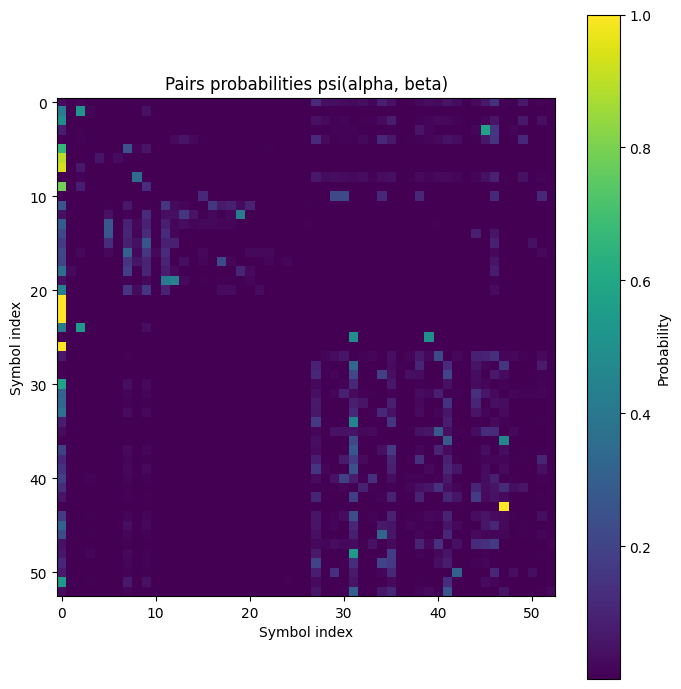

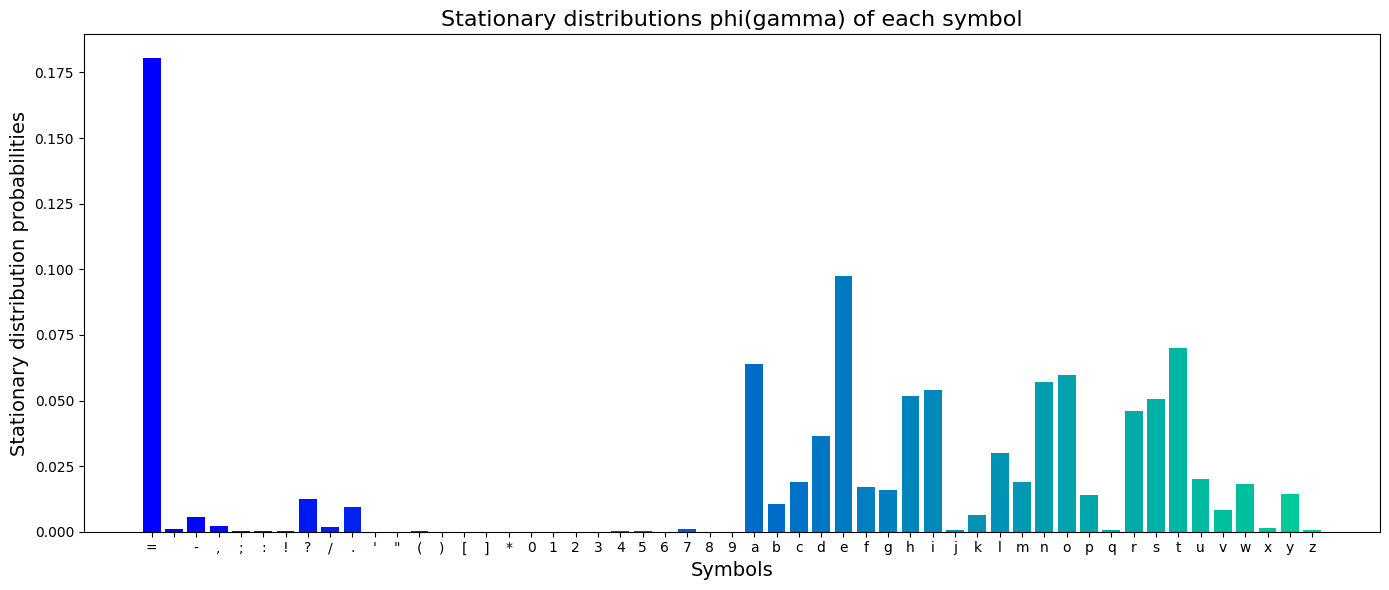

Iteration  0  :  3/e[oeo](/4she6/'e[]hse2(z/sh6czseos6hde[oeb6p,she462se[sed]
Iteration  100  :   nla6l6!ingshlontla!hsluicnsho'csl6sohdla6l,opbshlgouslasld!
Iteration  200  :  enla;l;uingstlonblautsl"icnsto'csl;sotdla;lmo ystlgo"slasldu
Iteration  300  :  enly;l;uongstlinblyutsl"ocnsti'csl;sitdly;lmi astlgi"slysldu
Iteration  400  :  enly;l;uoncstlinblyutsl'ognsti"gsl;sitdly;lki astlci'slysldu
Iteration  500  :  lnew.e.ouncsteinbewotse'ugnsti;gse.sitdew.eki asteci'sewsedo
Iteration  600  :  lnew.e.ounksteinyewotse'ugnsti,gse.sitmew.epi asteki'sewsemo
Iteration  700  :  lnew.e.ounksteinyewotse'ugnsti,gse.sitmew.epi asteki'sewsemo
Iteration  800  :  lnew.e.ounksteinyewotse'ugnstibgse.sitmew.epi asteki'sewsemo
Iteration  900  :  ln w. .ounkes inh wose 'ugnesibge .eism w. pitaes ki'e we mo
Iteration  1000  :  ln wh hounkes in. wose cugnesibge heism wh pitaes kice we mo
Iteration  1100  :  ln wa aounkes inf wose cugnesibge aeism wa pithes kice we mo
Iteration  1200  :  ln wa aounkes inf wo

In [ ]:
def main():

    symbols_list, message, warpeace_clean = text_cleaning()
    symbols_found, pair_found = transition_counts(warpeace_clean)
    psi, stationary_distribution_dict, symbol_indexes, stationary_probabilities = psi_phi_calculations(symbols_found, pair_found)

    plot_heatmap_transition(psi)
    plot_bar_stationary(symbols_list, stationary_probabilities)


    save_plots = False
    if save_plots:
        save_csv_data_transition(psi, symbols_list)
        save_csv_data_stationary(stationary_distribution_dict)


    proposal_encoding = random_proposal(symbols_list)
    mapping_obtained = decrypting_message_final(message, symbols_list, stationary_distribution_dict, stationary_probabilities, psi, symbol_indexes, n_iterations=20000, random_map=False)

    # Decrypting the entire message
    print("Original encoding : ", decrypting_first60(mapping=proposal_encoding, message=message, end=(len(message)-1)))
    print("Decoded text : ", decrypting_first60(mapping=mapping_obtained[-1],  message=message, end=(len(message)-1)))
    
    save_mapping(proposal_encoding, 'initial_mapping.csv')
    
main()